## 3. Gradient Boosting Machine

- Boosting algorithm: 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 대표적인 종류:  
1) AdaBoost  
2) GradientBoosting

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                               if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    feature_name_df = pd.read_csv(r'C:\Users\uos\Desktop\mc\data\UCI HAR Dataset\UCI HAR Dataset\features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    x_train = pd.read_csv(r'C:\Users\uos\Desktop\mc\data\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt',sep='\s+', names=feature_name )
    x_test = pd.read_csv(r'C:\Users\uos\Desktop\mc\data\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt',sep='\s+', names=feature_name)
    
    y_train = pd.read_csv(r'C:\Users\uos\Desktop\mc\data\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(r'C:\Users\uos\Desktop\mc\data\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [9]:
start_time=time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(x_train,y_train)
gb_pred = gb_clf.predict(x_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print('GBM Accuracy:{0:.4f}'.format(gb_accuracy))
print('GBM time: {0:.1f} second'.format(time.time()-start_time))

C:\Users\uos\miniconda3\envs\deep\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GBM Accuracy:0.9389
GBM time: 554.9 second


###  - Hyperparameter tuning


- loss : cost function (기본값: deviance)
- learning rate
- n_estimators : weak learner 의 개수 (기본 값: 100)
- subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율 (기본값:1)

In [ ]:
#GridSearchCV 로 Hyperparamter optimization
gbm_params = {'n_estimators':[100,500], 'learning rate':[0.05, 0.1]}
grid_gb = GridSearchCV(gb_clf,param_grid = gbm_params, cv=2, verbose=1)
grid_gb.fit(x_train,y_train)
print('best hyperparamter:', grid_gb.best_params_)
print('best score:{0:.4f}'.format(grid_gb.best_score_))

# predict
gb_pred = grid_gb.best_estimator_.predict(x_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print('GBM Accuracy: {0:.4f}'.format(gb_accuracy))

  
## 4. XGBOOST

- GBM 기반의 모델이지만, GBM의 단점인 느린 수행시간 및 과적합 등의 문제를 해결한 모델
- CPU 환경에서 병렬학습 가능
- 교차 검증이 자체 내장되어 있음
- 결손 값 자체 처리 가능

#### 1) 일반  파라미터  
- booster : gbtree, gblinear (기본값 gbtree)
- slient : default는 0이며, 출력메시지를 나타내고 싶지 않을 경우 1로 설정
- nthread : CPU의 실행 thread 개수 조정

#### 2) 부스터 파라미터
- eta[default=0.3, alias:learning_rate]: GBM의
- num_boost_rounds : n_estimators
- min_child_weight : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. (기본값:1)
- gamma : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소, 값이 클수록 과적합 감소 효과 (기본값: 0)
- max_depth (기본값: 6)
- sub_sample : GBM의 subsample과 같은 파라미터
- colsample_bytree : GBM의 max_features와 유사, 트리 생성에 필요한 feature(column)를 임의로 샘플링하는 데 사용됩니다. (기본값: 1)
- lambda : L2 Regularization 적용 값. (기본값: 1)
- alpha : L1 Regularization 적용 값, (기본값: 0)
- scale_pos_weight : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터 (기본값: 1)

#### 3) 학습 태스크 파라미터

- objective : 손실함수
- binary:logistic : 이진분류일 때 적용
- multi:softmax : 다중분류일 때 적용, num_class 파라미터 지정해야함
- multi:softprob : multi:softmax와 유사, 예측확률 반환
- eval_metric : 검증에 사용되는 함수를 정의 (rmse, mase, logloss, error, merror, mlogloss, auc)

#### - 과적합 시 적용사항
- eta 값 낮춤, eta 값 낮출 시 num_round는 반대로 높여줘야함
- max_depth 낮춤
- min_child_weight 높임
- gamma 높임
- subsample과 colsample_bytree 조정

In [18]:
cancer = load_breast_cancer()
x_feature = cancer.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=x_feature, columns=cancer.feature_names)
cancer_df['target'] = y_label
cancer_df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [19]:
print(cancer.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_feature, y_label, test_size=0.2, random_state=156)

In [25]:
# DMatrix 데이터 생성
dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(data=x_test,label=y_test)

In [28]:
xgboost_params = {'max_depth' : 3,
                   'eta' : 0.1, 
                   'objective' : 'binary:logistic',
                   'eval_metric' : 'logloss',
                   'early_stoppings' : 100 }
num_rounds= 400

In [29]:
wlist=[(dtrain,'train'),(dtest,'eval')]

In [30]:
xgb_model = xgb.train(params = xgboost_params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292592	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

In [31]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]


In [35]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
xgb_preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', xgb_preds[:10])

예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [38]:
def clf_evaluation(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred_proba)
    print('ConfusionMatrix:')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}, ROC_AUC: {4:.4f}'.format(accuracy,precision,recall,f1,roc_score))

In [39]:
clf_evaluation(y_test,xgb_preds,pred_probs)

ConfusionMatrix:
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision: 0.9744, recall: 0.9870, F1: 0.9806, ROC_AUC: 0.9951


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

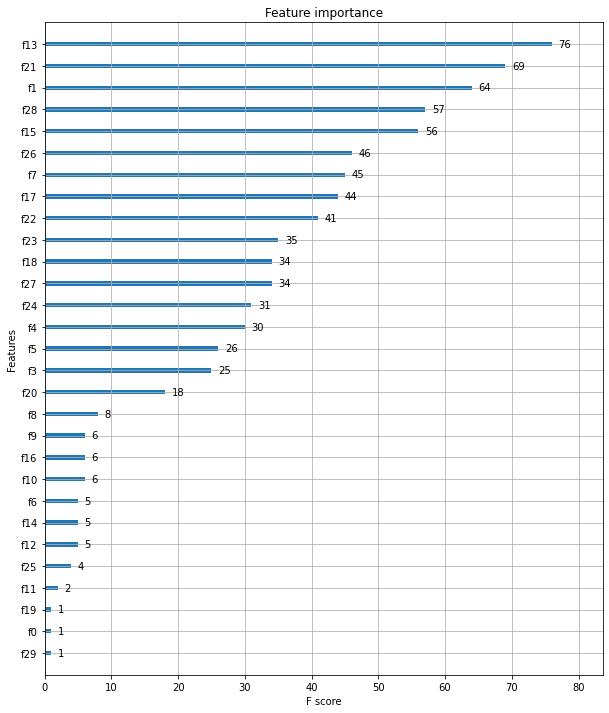

In [40]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

In [45]:
# 사이킷런 래퍼 XGBOOST
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(x_train, y_train)
w_preds = xgb_wrapper.predict(x_test)
w_pred_proba = xgb_wrapper.predict_proba(x_test)[:, 1]
clf_evaluation(y_test, w_preds, w_pred_proba)

ConfusionMatrix:
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision: 0.9744, recall: 0.9870, F1: 0.9806, ROC_AUC: 0.9951


#### early stoppiing 설정해서 평가

In [46]:
## Testset을 평가를 위한 set으로 사용 (validation set으로 활용)
evals = [(x_test,y_test)]
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=100 , eval_metric='logloss', eval_set=evals, verbose =True)
ws100_preds = xgb_wrapper.predict(x_test)
ws100_pred_proba = xgb_wrapper.predict_proba(x_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [47]:
clf_evaluation(y_test, ws100_preds, ws100_pred_proba)

ConfusionMatrix:
[[34  3]
 [ 1 76]]
accuracy: 0.9649, precision: 0.9620, recall: 0.9870, F1: 0.9744, ROC_AUC: 0.9954


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

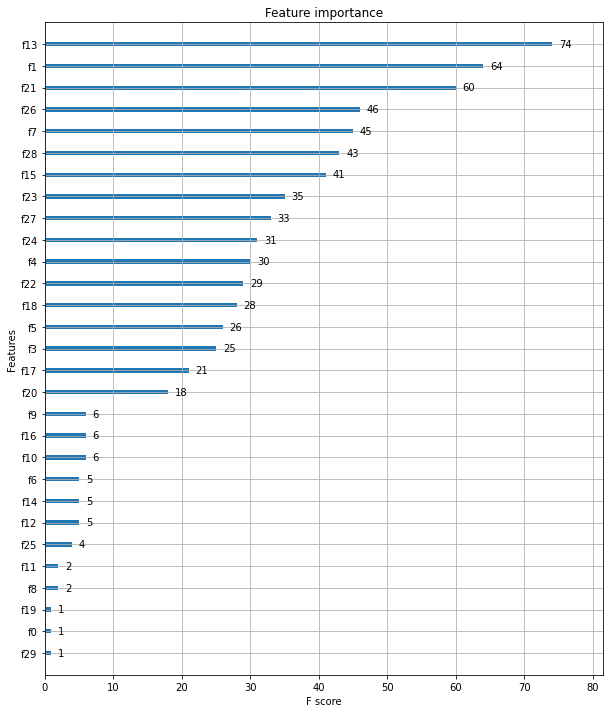

In [49]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)

## 5. LightGBM

In [64]:
dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

x_train, x_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(x_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)

lgbm_preds = lgbm_wrapper.predict(x_test)
lgbm_proba = lgbm_wrapper.predict_proba(x_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

In [65]:
clf_evaluation(y_test, lgbm_preds, lgbm_proba)

ConfusionMatrix:
[[33  4]
 [ 1 76]]
accuracy: 0.9561, precision: 0.9500, recall: 0.9870, F1: 0.9682, ROC_AUC: 0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

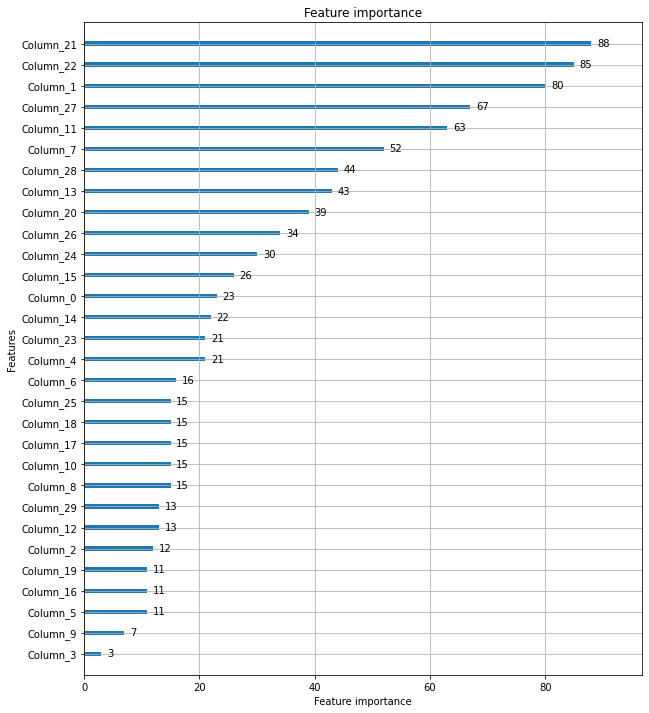

In [67]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)